# Economic Complexity Index correlation
In this notebook we explore the hypothesis that financial social capital captures similar information than the index of economic complexity. 

For this purpose, we downloaded the index of economic complexity from the observatory of economic complexity https://legacy.oec.world/en/rankings/country/eci/.

In [1]:
try:
    output_filepath
except:
    output_filepath = '../data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import country_converter as coco

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

from linearmodels.panel import BetweenOLS, PooledOLS
import patsy

In [3]:
data_path = os.path.join(Path(output_filepath).parent.resolve(), 'raw', 'eci_country_rankings.csv')
df_eci = pd.read_csv(data_path)
df_eci.columns = [c.lower() for c in df_eci]

iso3_converter = dict(zip(list(df_eci.country.unique()), coco.convert(list(df_eci.country.unique()))))
df_eci['country'] = df_eci.country.map(iso3_converter)

In [4]:
df_model = pd.read_parquet(os.path.join(output_filepath, 'panel_data.parquet'))
centralities = ['pagerank', 'gfi', 'bridging', 'favor']

In [5]:
df = df_model.merge(df_eci, on=['year', 'country'], how='inner')

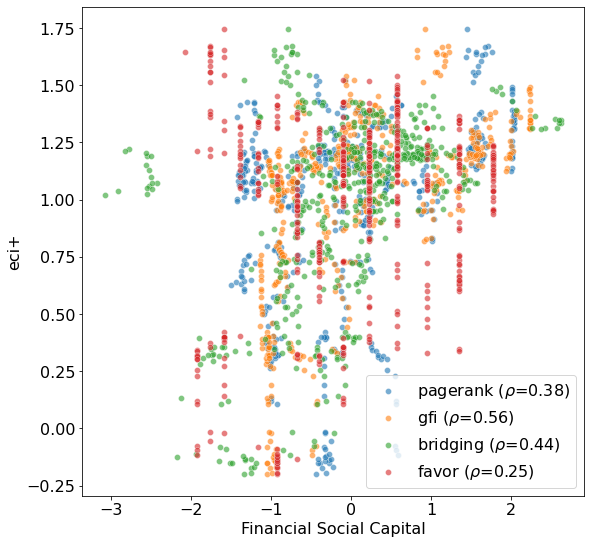

In [6]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(9,9))

for c in centralities:
    sns.scatterplot(df['financial_'+c], 
                y = df['eci+'], 
                ax=ax, 
                label = c, 
                alpha = 0.6)
    
plt.xlabel('Financial Social Capital')
plt.legend()


leg = ax.get_legend()
L_labels = leg.get_texts()
for i, l in enumerate(L_labels):
    centrality = l.get_text()
    corr = pearsonr(df['eci'], df['financial_' + centrality])[0]
    text = centrality + f' ($\\rho$={round(corr,2)})'
    L_labels[i].set_text(text)
    
save_to = os.path.join(Path(output_filepath).parent.parent.resolve(), 'reports', 'figures', 'financial_social_capital_vs_eci.png')
plt.savefig(save_to)    
plt.show()

In [7]:
df_correlations = pd.DataFrame({'centrality':centralities})

df_correlations['eci pearson'], df_correlations['eci p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df['eci'], df['financial_'+x])))
df_correlations['eci spearman'], df_correlations['eci p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df['eci'], df['financial_'+x])))

df_no_missing = df.dropna(subset = ['eci+'])
df_correlations['eci+ pearson'], df_correlations['eci+ p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df_no_missing['eci+'], df_no_missing['financial_'+x])))
df_correlations['eci+ spearman'], df_correlations['eci+ p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df_no_missing['eci+'], df_no_missing['financial_'+x])))

df_correlations

,centrality,eci pearson,eci p-value pearsonr,eci spearman,eci p-value spearman,eci+ pearson,eci+ p-value pearsonr,eci+ spearman,eci+ p-value spearman
0,pagerank,0.377241,8.091967e-21,0.365638,1.449352e-19,0.360320,4.124529e-17,0.400895,3.764992e-21
1,gfi,0.560066,1.267830e-48,0.612631,2.488619e-60,0.557612,4.345224e-43,0.643245,5.167208e-61
2,bridging,0.435620,6.161146e-28,0.438574,2.460257e-28,0.442178,7.125823e-26,0.447392,1.617061e-26
3,favor,0.248206,1.712762e-09,0.217598,1.436486e-07,0.213856,1.066238e-06,0.127829,3.798475e-03


In [8]:
f = 'eci ~ financial_pagerank + financial_gfi + financial_bridging + financial_favor + 1'
y, X = patsy.dmatrices(f, df.set_index(['country','year']),  return_type='dataframe')

model = PooledOLS(y,X)
pooled_res = model.fit()

pooled_res

Dep. Variable:,eci,R-squared:,0.4670
Estimator:,PooledOLS,R-squared (Between):,0.5084
No. Observations:,573,R-squared (Within):,-0.3951
Date:,"Tue, Mar 02 2021",R-squared (Overall):,0.4670
Time:,16:05:27,Log-likelihood,-381.26
Cov. Estimator:,Unadjusted,,
,,F-statistic:,124.42
Entities:,32,P-value,0.0000
Avg Obs:,17.906,Distribution:,"F(4,568)"
Min Obs:,15.000,,
Max Obs:,18.000,F-statistic (robust):,124.42
